In [1]:
import pyupbit
import time
from collections import deque
tickers = []
# 코인 종가를 담을 deque 변수
ma5 = deque(maxlen = 5)
ma20 = deque(maxlen = 20)
ma60 = deque(maxlen = 60)

# 원화로 거래 가능한 코인 리스트
tickers = pyupbit.get_tickers(fiat = 'KRW')
# ['KRW-BTC', 'KRW-ETH', 'KRW-NEO', 'KRW-MTL', 'KRW-LTC'] ... 등등

# 로그인 정보 저장
#upbit = pyupbit.Upbit('wFAuJTKFqiSCj1xWXUW9juzMSlCDELPqcN2j2t2b', 'Z5bI1gRI2C7SyhvlqPOMbMsDQcbcKLrpcxe6wmGL')

'''get_ohlcv 함수는 고가/시가/저가/종가/거래량을 DataFrame으로 반환합니다'''
df = pyupbit.get_ohlcv(
    tickers[0], interval='minute5', to='20221101')  # 일봉 데이터 프레임 생성

ma5.extend(df['close'])    # ma20 변수에 종가 넣기
ma20.extend(df['close'])    # ma60 변수에 종가 넣기
ma60.extend(df['close'])   # ma120 변수에 종가 넣기

df['date'] = df.index

ma5 = df['close'].rolling(window=5).mean()
df.insert(len(df.columns), "MA5", ma5)

ma20 = df['close'].rolling(window=20).mean()
df.insert(len(df.columns), "MA20", ma20)

ma60 = df['close'].rolling(window=60).mean()
df.insert(len(df.columns), "MA60", ma60)
df = df[-100:]
print(df)
print(type(df))

                           open        high         low       close  \
2022-11-01 00:40:00  28680000.0  28692000.0  28675000.0  28688000.0   
2022-11-01 00:45:00  28688000.0  28702000.0  28679000.0  28702000.0   
2022-11-01 00:50:00  28702000.0  28779000.0  28701000.0  28779000.0   
2022-11-01 00:55:00  28779000.0  28790000.0  28672000.0  28713000.0   
2022-11-01 01:00:00  28713000.0  28713000.0  28674000.0  28701000.0   
...                         ...         ...         ...         ...   
2022-11-01 08:35:00  28763000.0  28767000.0  28762000.0  28763000.0   
2022-11-01 08:40:00  28763000.0  28767000.0  28761000.0  28762000.0   
2022-11-01 08:45:00  28766000.0  28779000.0  28763000.0  28776000.0   
2022-11-01 08:50:00  28775000.0  28780000.0  28763000.0  28778000.0   
2022-11-01 08:55:00  28778000.0  28780000.0  28778000.0  28778000.0   

                        volume         value                date         MA5  \
2022-11-01 00:40:00   8.046057  2.307748e+08 2022-11-01 00:40:00  2

In [2]:
import pandas as pd
def Stochastick(df, n = 10, m = 3, t = 3):
    ndays_high = df.high.rolling(window = n, min_periods = 1).max()
    ndays_low = df.low.rolling(window=n, min_periods=1).min()
    fast_k = ((df.close - ndays_low) / (ndays_high - ndays_low)) * 100
    slow_k = fast_k.ewm(span=m).mean()
    slow_d = slow_k.ewm(span=t).mean()
    df = df.assign(fast_k = fast_k, fast_d = slow_k, slow_k = slow_k, slow_d = slow_d)
    return df

def SMA(data, period = 30, column = 'close'):
    return data[column].rolling(window = period).mean()

def RSI(data, period = 14, column = 'close'):
    delta = data[column].diff(1)
    delta = delta.dropna()
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    data['up'] = up
    data['down'] = down
    AVG_Gain = SMA(data, period, column = 'up')
    AVG_Loss = abs(SMA(data, period, column = 'down'))
    RS = AVG_Gain / AVG_Loss
    RSI = 100.0 - (100.0 / (1.0 + RS))
    data['RSI'] = RSI
    return data

df = Stochastick(df, 10, 3, 3)
df = RSI(df, 14)
df['AP'] = (df['high'] + df['low'] + df['close']) / 3
df['SMA'] = df['AP'].rolling(10).mean()
df['ADV'] = df['AP'].rolling(10).apply(lambda x: pd.Series(x).mad())
df['CCI'] = (df['AP'] - df['SMA']) / (0.015 * df['ADV'])

C:\Users\kkaa5\AppData\Local\Temp\ipykernel_6844\138456612.py:34: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  df['ADV'] = df['AP'].rolling(10).apply(lambda x: pd.Series(x).mad())


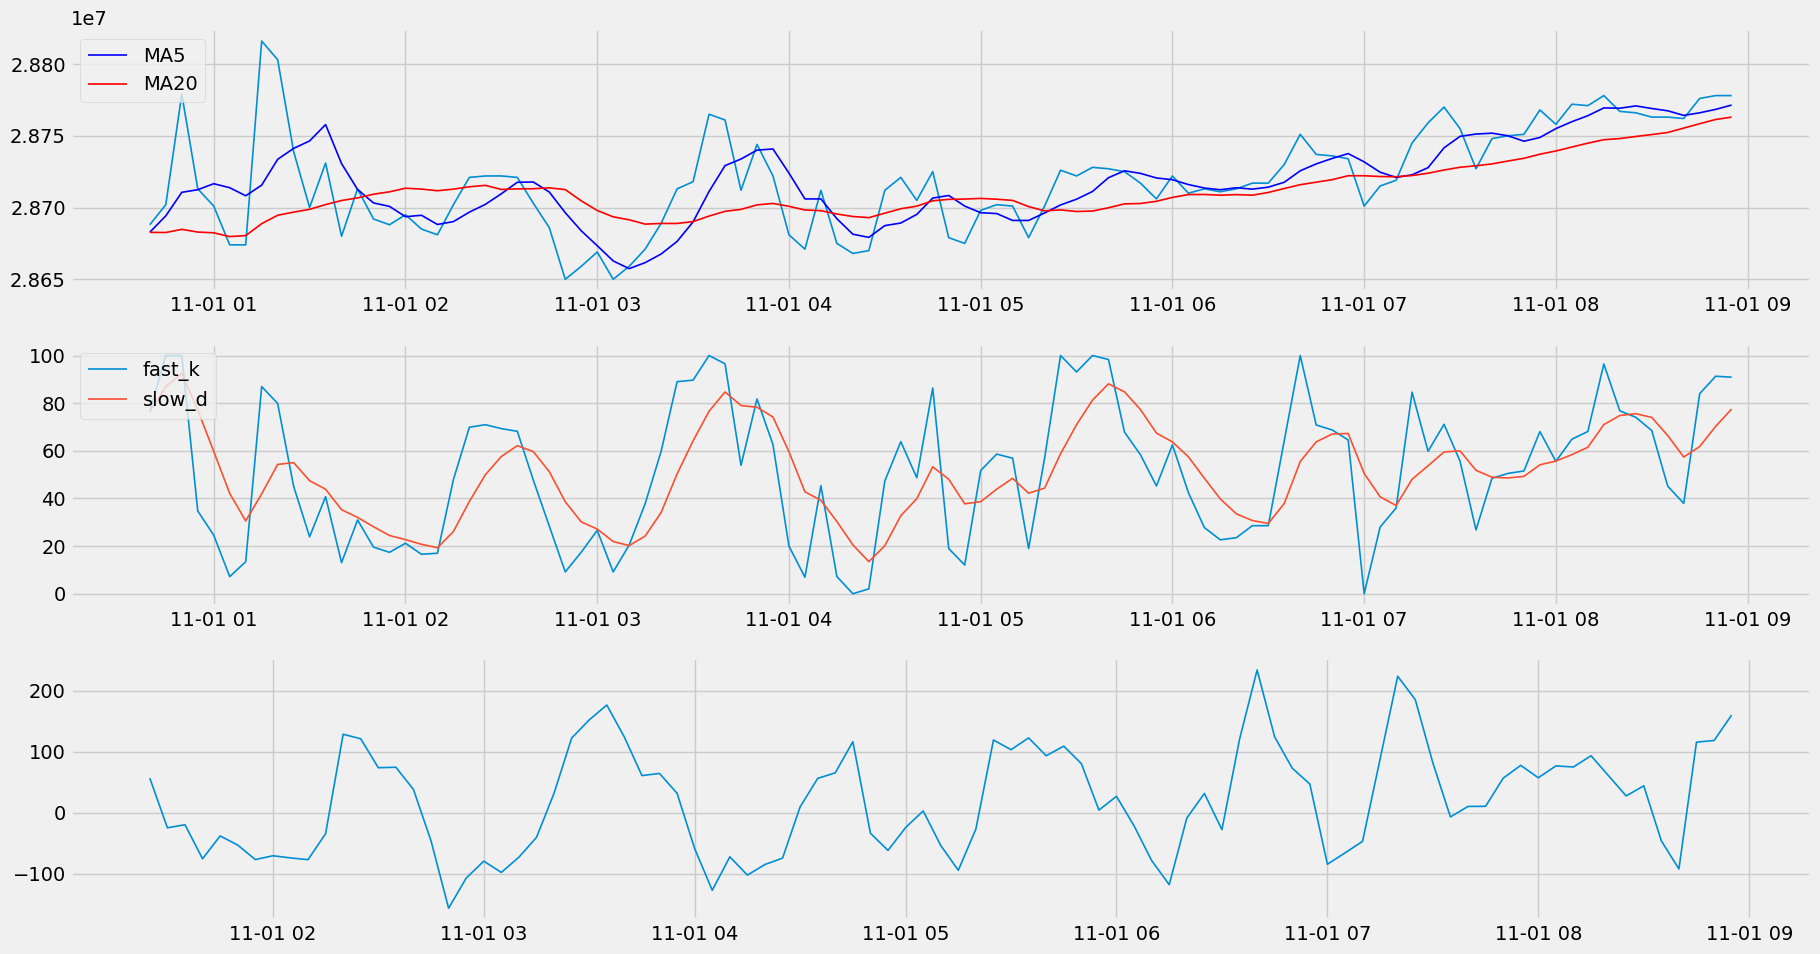

In [3]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 11))
plt.subplot(3, 1, 1)
plt.plot(df['close'], lw=1.2)
plt.plot(df['date'], df['MA5'], 'b', label='MA5', lw=1.2)
plt.plot(df['date'], df['MA20'], 'r', label='MA20', lw=1.2)
plt.legend(loc = 'upper left')
plt.subplot(3, 1, 2)
plt.plot(df['fast_k'], label='fast_k', lw=1.2)
plt.plot(df['slow_d'], label='slow_d', lw=1.2)
plt.legend(loc = 'upper left')
plt.subplot(3, 1, 3)
plt.plot(df['CCI'], label = 'CCI', lw = 1.2)
plt.show()